# 4526 Midterm Solution:
Arun Agarwal

## Imports:

In [1]:
#Basic Imports:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import word_tokenize
import re
import math
from collections import Counter

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import tree
from sklearn.datasets import make_blobs
from sklearn import datasets

# Preprocessing Imports
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")
from random import shuffle
import random
random.seed(123)
from utils.syntactic_similarity_measures import SyntacticMeasures
from utils.lesk_algorithm import Lesk
from utils.semantic_similarity_measures import SemanticMeasures

# Model Imports:
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
from sklearn import svm

# Metrics Import
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report 
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics.cluster import normalized_mutual_info_score

## Functions:

In [2]:
def get_baseline_results_for_single_classifier(data, target_col, clf, filename):
    X, y = data.drop(target_col, axis=1), data[target_col]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)
    clf = clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)
    report = classification_report(y_te, y_pred, output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f'../Data/baseline_results/{filename}.csv')
    return report

In [3]:
def decompose_error(model, data, target_name, loss='mse'):
    X, y = data.drop(target_name, axis=1), data[target_name]
    X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model, X_tr.values, y_tr.values, X_te.values, y_te.values, 
        loss=loss,
        random_seed=42)
    print("Average Expected Loss: ", avg_expected_loss)
    print("Average Bias: ", avg_bias)
    print("Average Variance: ", avg_var)
    
    return avg_expected_loss, avg_bias, avg_var

In [4]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [5]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [6]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

In [7]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, w = None, _C=1.0):
    model = LogisticRegression(C=_C, class_weight = w, fit_intercept = True, penalty = 'l2').fit(X_tr, y_tr)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    print('Accuracy Score with', description, 'model/features', score)
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    report = classification_report(y_test, y_pred,output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f'LogisticRegression{description}.csv')
    return model

In [8]:
def simple_svm_classify(X_tr, y_tr, X_test, y_test, description, w = None):
    svmClassifier = svm.SVC(kernel='rbf', class_weight = w).fit(X_tr, y_tr)
    y_pred = svmClassifier.predict(X_test)
    score = svmClassifier.score(X_test, y_test)
    print('Accuracy Score with', description, 'model/features', score)
    print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
    print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
    print(f'Recall Score: {recall_score(y_test,y_pred)}')
    print(f'Precision Score: {precision_score(y_test,y_pred)}')
    report = classification_report(y_test, y_pred,output_dict=True)
    pd.DataFrame(report).transpose().to_csv(f'SupportVectorMachine{description}.csv')
    return svmClassifier

In [9]:
def compute_cosine_similarity(token1, token2):
        """ compute cosine similarity """
        cosine_similarity = SyntacticMeasures.getCosineSimilarity(token1,token2)
        return cosine_similarity

In [10]:
def compute_jaccard_similarity(token1, token2):
        """ compute jaccard similarity"""
        jaccard_similarity = SyntacticMeasures.normal_jaccard_distance(token1,token2)
        return jaccard_similarity

In [11]:
def compute_lemma_jaccard_similarity(lemma1, lemma2):
        """ compute lemma jaccard similarity"""
        lemma_jaccard_similarity = SyntacticMeasures.lemma_jaccard_distance(lemma1,lemma2)
        return lemma_jaccard_similarity

In [12]:
def compute_combined_score_syn(r1, r2, r3):
        """ get the combined score"""
        return (r1+r2+r3)/ 3

In [13]:
def overall_similarity_combined(token1, token2, lemma1, lemma2):
        """ calculate combined similarity """

        R1 = compute_cosine_similarity(token1,token2)
        R2 = compute_jaccard_similarity(token1,token2)
        R3 = compute_lemma_jaccard_similarity(lemma1,lemma2)
        R = compute_combined_score_syn(R1,R2,R3)
        return R

In [14]:
 def get_lesk(ques):
        """ get each word meaning out of the given question"""
        lesk_obj = Lesk(ques)
        sentence_means = []
        for word in ques:
            sentence_means.append(lesk_obj.lesk(word, ques))
        return sentence_means

In [15]:
def compute_path_similarity(sentence_means1, sentence_means2):
        """ get the path similarity score for two sentences"""
        score = SemanticMeasures.computePath(sentence_means1, sentence_means2)
        return score

In [16]:
def compute_combined_score(r1, r2):
        """ get the combined score"""
        return (r1+r2)/ 2

In [17]:
 def compute_wup_similarity(sentence_means1, sentence_means2):
        """ get the wup similarity score for two sentences"""
        score = SemanticMeasures.computeWup(sentence_means1, sentence_means2)
        return score

In [18]:
 def overall_similarity_combined_semantic(ques1, ques2):
        """ calculate combined similarity """
        sentence_means1 = get_lesk(ques1)
        sentence_means2 = get_lesk(ques2)

        R1 = compute_path_similarity(sentence_means1, sentence_means2)
        R2 = compute_wup_similarity(sentence_means1, sentence_means2)

        R = compute_combined_score(R1,R2)
        return SemanticMeasures.overallSim(sentence_means1, sentence_means2, R)

In [19]:
def overall_similarity_wup_similarity(ques1, ques2):
        """ calculate wup similarity """
        sentence_means1 = get_lesk(ques1)
        sentence_means2 = get_lesk(ques2)

        R1 = compute_wup_similarity(sentence_means1, sentence_means2)

        return SemanticMeasures.overallSim(sentence_means1, sentence_means2, R1)

In [20]:
 def overall_similarity_path_similarity(ques1, ques2):
        """ calculate path similarity """
        sentence_means1 = get_lesk(ques1)
        sentence_means2 = get_lesk(ques2)

        R1 = compute_path_similarity(sentence_means1, sentence_means2)

        return SemanticMeasures.overallSim(sentence_means1, sentence_means2, R1)

## Data Preprocessing:

In [21]:
#Settings:
pd.set_option('max_colwidth', 500)

### Creating Balanced Training Dataset Instance:

In [115]:
train_df = pd.read_csv("train_df")
subset0 = train_df.loc[train_df['classification'] == 0]
subset1 = train_df.loc[train_df['classification'] == 1]
subset1Sample = subset1.sample(n=1039,random_state=42)
new_train_df = subset0.append(subset1Sample)

In [116]:
train_df['classification'].value_counts()/train_df.shape[0]

1    0.745156
0    0.254844
Name: classification, dtype: float64

In [117]:
new_train_df['classification'].value_counts()/new_train_df.shape[0]

0    0.5
1    0.5
Name: classification, dtype: float64

<AxesSubplot:xlabel='overall_sim_score', ylabel='overall_similarity_combined_semantic'>

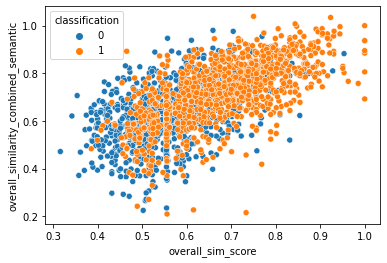

In [118]:
sns.scatterplot(data=new_train_df,x='overall_sim_score',y='overall_similarity_combined_semantic',hue='classification')

### Training Dataset Preprocessing:

In [21]:
#Training Dataset:
train_df = pd.read_csv("train_with_label.txt", delimiter = "r'\t", header = None, engine = 'python')
train_df = train_df[0].str.split("\t", expand=True)
train_df = train_df.rename(columns={0: "id", 1: "sentence1", 2: "sentence2", 3: "classification"})
train_df["classification"] = pd.to_numeric(train_df["classification"])
train_df.drop_duplicates(inplace = True)

lemm = nltk.stem.WordNetLemmatizer()

train_df['Text_Cleaned1'] = list(map(clean_text, train_df.sentence1))
train_df['lemmatized_text1'] = list(map(lambda word:list(map(lemm.lemmatize, word)),train_df.Text_Cleaned1))
train_df['Text_Cleaned2'] = list(map(clean_text, train_df.sentence2))
train_df['lemmatized_text2'] = list(map(lambda word:list(map(lemm.lemmatize, word)),train_df.Text_Cleaned2))

In [23]:
#Syntactic Features:
cosineOldlist = []
similaritylist = []
lengthlist = []
overlaplist = []
overlap2list = []

for index, row in train_df.iterrows():
    #Cosine Similarity:
    counter1 = Counter(row['Text_Cleaned1'])
    counter2 = Counter(row['Text_Cleaned2'])
    cosine_score = counter_cosine_similarity(counter1, counter2)
    cosineOldlist.append(cosine_score)
    
    #Length Similarity:
    lenc1 = sum(iter(counter1.values()))
    lenc2 = sum(iter(counter2.values()))
    lengthSim = min(lenc1, lenc2) / float(max(lenc1, lenc2))
    lengthlist.append(lengthlist)
    
    #Overlapping Words/Sentence Length 1 - Overlapping Words/Sentence Length 2:
    overlappingtermsCount = sum(((counter1)&(counter2)).values())
    overlap_score = (overlappingtermsCount/lenc1) - (overlappingtermsCount/lenc2)
    overlaplist.append(overlap_score)
    
    #Overlapping Words/(Sentence Length 1 + Sentence Length 2):
    overlap2_score = (overlappingtermsCount/(lenc1+lenc2))
    overlap2list.append(overlap2_score)
    
    #Similarity Score:
    similarityScore = lengthSim * cosine_score
    similaritylist.append(similarityScore)
    
train_df['cosine_similarity_score'] = cosineOldlist
train_df['cosine/length_ratio'] = similaritylist
train_df['length_similarity'] = lengthlist
train_df['overlap_score'] = overlaplist
train_df['overlap2_score'] = overlap2list    

In [24]:
train_df

MemoryError: 

KeyboardInterrupt: 

In [25]:
#Syntactic Features More Scores:
cosinelist = []
jaccardlist = []
lemmajaccardlist = []
overallsimilaritylist = []

for index, row in train_df.iterrows():
    cosine_score = compute_cosine_similarity(row['Text_Cleaned1'], row['Text_Cleaned2'])
    jaccard_score = compute_jaccard_similarity(row['Text_Cleaned1'], row['Text_Cleaned2'])
    lemma_jaccard_score = compute_lemma_jaccard_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overall_sim_score = overall_similarity_combined(row['Text_Cleaned1'], row['Text_Cleaned2'], row['lemmatized_text1'], row['lemmatized_text2'])
    cosinelist.append(cosine_score)
    jaccardlist.append(jaccard_score)
    lemmajaccardlist.append(lemma_jaccard_score)
    overallsimilaritylist.append(overall_sim_score)
train_df['cosine_similarity_score2'] = cosinelist
train_df['jaccard_similarity_score'] = jaccardlist
train_df['lemma_jaccard_score'] = lemmajaccardlist
train_df['overall_sim_score'] = overallsimilaritylist
train_df

KeyboardInterrupt: 

In [39]:
df1 = train_df.iloc[:800]
df2 = train_df.iloc[800:1600]
df3 = train_df.iloc[1600:2400]
df4 = train_df.iloc[2400:3200]
df5 = train_df.iloc[3200:4077]

In [40]:
#Semantic Features:
overallSimCombined = []
overallSimWUP = []
overallSimPath = []
for index, row in df1.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)

In [41]:
for index, row in df2.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)

In [42]:
for index, row in df3.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)

In [43]:
for index, row in df4.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)

In [44]:
for index, row in df5.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)

In [45]:
train_df = df1.append(df2).append(df3).append(df4).append(df5)

In [46]:
train_df['overall_similarity_combined_semantic'] = overallSimCombined
train_df['overall_similarity_wup_semantic'] = overallSimWUP
train_df['overall_similarity_path_semantic'] = overallSimPath
train_df 

,id,sentence1,sentence2,classification,Text_Cleaned1,lemmatized_text1,Text_Cleaned2,lemmatized_text2,cosine_similarity_score,overall_similarity_score,cosine_similarity_score2,jaccard_similarity_score,lemma_jaccard_score,overall_sim_score,overall_similarity_combined_semantic,overall_similarity_wup_semantic,overall_similarity_path_semantic
0,train_id_0,The Democratic candidates also began announcin...,The Democratic candidates also began announcin...,1,"[democratic, candidates, also, began, announci...","[democratic, candidate, also, began, announcin...","[democratic, candidates, also, began, announci...","[democratic, candidate, also, began, announcin...",0.909509,0.856008,0.970143,0.833333,0.833333,0.878936,0.917869,0.919913,0.915825
1,train_id_1,The woman was exposed to the SARS virus while ...,The woman was exposed to the SARS virus while ...,1,"[woman, exposed, sars, virus, hospital, health...","[woman, exposed, sars, virus, hospital, health...","[woman, exposed, sars, virus, hospital, health...","[woman, exposed, sars, virus, hospital, health...",0.904534,0.804030,0.954786,0.937500,0.937500,0.943262,0.873775,0.870098,0.877451
2,train_id_2,He said the problem needs to be corrected befo...,He said the prob lem needs to be corrected bef...,1,"[said, problem, needs, corrected, space, shutt...","[said, problem, need, corrected, space, shuttl...","[said, prob, lem, needs, corrected, space, shu...","[said, prob, lem, need, corrected, space, shut...",0.666667,0.666667,1.000000,0.500000,0.636364,0.712121,0.780159,0.825926,0.741799
3,train_id_3,A representative for Phoenix-based U-Haul decl...,"Anthony Citrano , a representative for WhenU ,...",0,"[representative, phoenix, based, u, haul, decl...","[representative, phoenix, based, u, haul, decl...","[anthony, citrano, representative, whenu, decl...","[anthony, citrano, representative, whenu, decl...",0.455842,0.290081,0.797724,0.285714,0.285714,0.456384,0.577681,0.681597,0.526984
4,train_id_4,The biggest threat to order seemed to be looti...,The biggest threat to order seemed to be looti...,1,"[biggest, threat, order, seemed, looting, crim...","[biggest, threat, order, seemed, looting, crim...","[biggest, threat, order, seemed, looting, crim...","[biggest, threat, order, seemed, looting, crim...",0.721688,0.541266,0.866025,0.555556,0.555556,0.659046,0.806662,0.818681,0.794643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4072,train_id_4072,"Axelrod died in his sleep of heart failure , s...",Axelrod died of heart failure while asleep at ...,1,"[axelrod, died, sleep, heart, failure, said, d...","[axelrod, died, sleep, heart, failure, said, d...","[axelrod, died, heart, failure, asleep, los, a...","[axelrod, died, heart, failure, asleep, los, a...",0.805823,0.604367,0.886405,0.583333,0.583333,0.684357,0.504819,0.534127,0.485714
4073,train_id_4073,"Saddam 's other son , Odai , surrendered Frida...","Hussein 's other son , Uday , surrendered yest...",1,"[saddam, son, odai, surrendered, friday, ameri...","[saddam, son, odai, surrendered, friday, ameri...","[hussein, son, uday, surrendered, yesterday, a...","[hussein, son, uday, surrendered, yesterday, a...",0.600000,0.600000,1.000000,0.428571,0.538462,0.655678,0.883333,0.883333,0.883333
4074,train_id_4074,If Senator Clinton does decide to run in 2008 ...,If Mrs Clinton does decide to contest the 2008...,1,"[senator, clinton, decide, run, 2008, cannot, ...","[senator, clinton, decide, run, 2008, cannot, ...","[mrs, clinton, decide, contest, 2008, election...","[mr, clinton, decide, contest, 2008, election,...",0.819892,0.756823,0.968963,0.714286,0.714286,0.799178,0.758261,0.791613,0.740000
4075,train_id_4075,"The Iranian refugee who sewed up his eyes , li...","An Iranian Kurd who stitched up his eyes , lip...",1,"[iranian, refugee, sewed, eyes, lips, ears, pr...","[iranian, refugee, sewed, eye, lip, ear, prote...","[iranian, kurd, stitched, eyes, lips, ears, pr...","[iranian, kurd, stitched, eye, lip, ear, prote..

In [47]:
train_df.to_csv("train_df", index = False)

### Development Dataset Pre-Processing:

In [56]:
#Validation Dataset:
dev_df = pd.read_csv("dev_with_label.txt", delimiter = "r'\t", header = None, engine = 'python')
dev_df = dev_df[0].str.split("\t", expand=True)
dev_df = dev_df.rename(columns={0: "id", 1: "sentence1", 2: "sentence2", 3: "classification"})
dev_df["classification"] = pd.to_numeric(dev_df["classification"])
dev_df.drop_duplicates(inplace = True)

lemm = nltk.stem.WordNetLemmatizer()

dev_df['Text_Cleaned1'] = list(map(clean_text, dev_df.sentence1))
dev_df['lemmatized_text1'] = list(map(lambda word:list(map(lemm.lemmatize, word)),dev_df.Text_Cleaned1))
dev_df['Text_Cleaned2'] = list(map(clean_text, dev_df.sentence2))
dev_df['lemmatized_text2'] = list(map(lambda word:list(map(lemm.lemmatize, word)),dev_df.Text_Cleaned2))

In [57]:
#Syntactic Features:
cosineOldlist = []
similaritylist = []
cosinelist = []
jaccardlist = []
lemmajaccardlist = []
overallsimilaritylist = []
for index, row in dev_df.iterrows():
    #Cosine Similarity:
    counter1 = Counter(row['Text_Cleaned1'])
    counter2 = Counter(row['Text_Cleaned2'])
    cosine_score = counter_cosine_similarity(counter1, counter2)
    cosineOldlist.append(cosine_score)
    
    #Length Similarity:
    lenc1 = sum(iter(counter1.values()))
    lenc2 = sum(iter(counter2.values()))
    lengthSim = min(lenc1, lenc2) / float(max(lenc1, lenc2))
    
    #Similarity Score:
    similarityScore = lengthSim * cosine_score
    similaritylist.append(similarityScore)
    
    #More Scores:
    cosine_score = compute_cosine_similarity(row['Text_Cleaned1'], row['Text_Cleaned2'])
    jaccard_score = compute_jaccard_similarity(row['Text_Cleaned1'], row['Text_Cleaned2'])
    lemma_jaccard_score = compute_lemma_jaccard_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overall_sim_score = overall_similarity_combined(row['Text_Cleaned1'], row['Text_Cleaned2'], row['lemmatized_text1'], row['lemmatized_text2'])
    cosinelist.append(cosine_score)
    jaccardlist.append(jaccard_score)
    lemmajaccardlist.append(lemma_jaccard_score)
    overallsimilaritylist.append(overall_sim_score)
dev_df['cosine_similarity_score'] = cosineOldlist
dev_df['overall_similarity_score'] = similaritylist
dev_df['cosine_similarity_score2'] = cosinelist
dev_df['jaccard_similarity_score'] = jaccardlist
dev_df['lemma_jaccard_score'] = lemmajaccardlist
dev_df['overall_sim_score'] = overallsimilaritylist
dev_df

,id,sentence1,sentence2,classification,Text_Cleaned1,lemmatized_text1,Text_Cleaned2,lemmatized_text2,cosine_similarity_score,overall_similarity_score,cosine_similarity_score2,jaccard_similarity_score,lemma_jaccard_score,overall_sim_score
0,dev_id_0,Local police authorities are treating the expl...,Acting New Haven Police Chief Francisco Ortiz ...,0,"[local, police, authorities, treating, explosi...","[local, police, authority, treating, explosion...","[acting, new, police, chief, francisco, ortiz,...","[acting, new, police, chief, francisco, ortiz,...",0.534522,0.400892,0.890871,0.333333,0.333333,0.519179
1,dev_id_1,The report shows that drugs sold in Canadian p...,The report shows that drugs sold in Canadian p...,1,"[report, shows, drugs, sold, canadian, pharmac...","[report, show, drug, sold, canadian, pharmacy,...","[report, shows, drugs, sold, canadian, pharmac...","[report, show, drug, sold, canadian, pharmacy,...",0.802955,0.661257,0.860309,0.705882,0.705882,0.757358
2,dev_id_2,The transition is slated to begin no later tha...,A two-week transition period will begin no lat...,1,"[transition, slated, begin, later, june, 7, da...","[transition, slated, begin, later, june, 7, da...","[two, week, transition, period, begin, later, ...","[two, week, transition, period, begin, later, ...",0.625000,0.625000,1.000000,0.454545,0.454545,0.636364
3,dev_id_3,"Like Viacom , GE -- parent of NBC -- is also s...","Like Viacom , General Electric is seen as a le...",1,"[like, viacom, ge, parent, nbc, also, seen, le...","[like, viacom, ge, parent, nbc, also, seen, le...","[like, viacom, general, electric, seen, less, ...","[like, viacom, general, electric, seen, le, en...",0.725241,0.569832,0.886405,0.562500,0.600000,0.682968
4,dev_id_4,"Last month , 62 Spanish peacekeepers died when...","In another disaster , 62 Spanish peacekeepers ...",1,"[last, month, 62, spanish, peacekeepers, died,...","[last, month, 62, spanish, peacekeeper, died, ...","[another, disaster, 62, spanish, peacekeepers,...","[another, disaster, 62, spanish, peacekeeper, ...",0.585369,0.495313,0.919866,0.411765,0.411765,0.581132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,dev_id_719,"He is a brother to three-year-old Mia , from K...","Winslet , 28 , has a three-year-old daughter M...",0,"[brother, three, year, old, mia, kate, first, ...","[brother, three, year, old, mia, kate, first, ...","[winslet, 28, three, year, old, daughter, mia,...","[winslet, 28, three, year, old, daughter, mia,...",0.694365,0.595170,0.925820,0.529412,0.529412,0.661548
720,dev_id_720,Some 175 million shares traded on the Big Boar...,Some 1.6 billion shares traded on the Big Boar...,0,"[175, million, shares, traded, big, board, 7, ...","[175, million, share, traded, big, board, 7, p...","[1, 6, billion, shares, traded, big, board, 17...","[1, 6, billion, share, traded, big, board, 17,...",0.462910,0.396780,0.925820,0.300000,0.300000,0.508607
721,dev_id_721,Mr Berlusconi is accused of bribing judges to ...,Mr Berlusconi is accused of bribing judges to ...,1,"[mr, berlusconi, accused, bribing, judges, inf...","[mr, berlusconi, accused, bribing, judge, infl...","[mr, berlusconi, accused, bribing, judges, inf...","[mr, berlusconi, accused, bribing, judge, infl...",0.716115,0.620633,0.930949,0.555556,0.555556,0.680687
722,dev_id_722,"He added that those "" are not solely American ...",""" These are not solely American principles nor...",1,"[added, solely, american, principles, exclusiv...","[added, solely, american, principle, exclusive...","[solely, american, principles, exclusively, we...","[solely, american, principle, exclusively, wes...",0.771517,0.661300,0.925820,0.625000,0.625000,0.725273


In [58]:
#Semantic Features:
overallSimCombined = []
overallSimWUP = []
overallSimPath = []
for index, row in dev_df.iterrows():
    R3 = overall_similarity_combined_semantic(row['lemmatized_text1'], row['lemmatized_text2'])
    R4 = overall_similarity_wup_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    R5 = overall_similarity_path_similarity(row['lemmatized_text1'], row['lemmatized_text2'])
    overallSimCombined.append(R3)
    overallSimWUP.append(R4)
    overallSimPath.append(R5)
dev_df['overall_similarity_combined_semantic'] = overallSimCombined
dev_df['overall_similarity_wup_semantic'] = overallSimWUP
dev_df['overall_similarity_path_semantic'] = overallSimPath
dev_df    

,id,sentence1,sentence2,classification,Text_Cleaned1,lemmatized_text1,Text_Cleaned2,lemmatized_text2,cosine_similarity_score,overall_similarity_score,cosine_similarity_score2,jaccard_similarity_score,lemma_jaccard_score,overall_sim_score,overall_similarity_combined_semantic,overall_similarity_wup_semantic,overall_similarity_path_semantic
0,dev_id_0,Local police authorities are treating the expl...,Acting New Haven Police Chief Francisco Ortiz ...,0,"[local, police, authorities, treating, explosi...","[local, police, authority, treating, explosion...","[acting, new, police, chief, francisco, ortiz,...","[acting, new, police, chief, francisco, ortiz,...",0.534522,0.400892,0.890871,0.333333,0.333333,0.519179,0.526301,0.584580,0.482766
1,dev_id_1,The report shows that drugs sold in Canadian p...,The report shows that drugs sold in Canadian p...,1,"[report, shows, drugs, sold, canadian, pharmac...","[report, show, drug, sold, canadian, pharmacy,...","[report, shows, drugs, sold, canadian, pharmac...","[report, show, drug, sold, canadian, pharmacy,...",0.802955,0.661257,0.860309,0.705882,0.705882,0.757358,0.828098,0.855122,0.803763
2,dev_id_2,The transition is slated to begin no later tha...,A two-week transition period will begin no lat...,1,"[transition, slated, begin, later, june, 7, da...","[transition, slated, begin, later, june, 7, da...","[two, week, transition, period, begin, later, ...","[two, week, transition, period, begin, later, ...",0.625000,0.625000,1.000000,0.454545,0.454545,0.636364,0.713095,0.743750,0.684524
3,dev_id_3,"Like Viacom , GE -- parent of NBC -- is also s...","Like Viacom , General Electric is seen as a le...",1,"[like, viacom, ge, parent, nbc, also, seen, le...","[like, viacom, ge, parent, nbc, also, seen, le...","[like, viacom, general, electric, seen, less, ...","[like, viacom, general, electric, seen, le, en...",0.725241,0.569832,0.886405,0.562500,0.600000,0.682968,0.770524,0.796260,0.749333
4,dev_id_4,"Last month , 62 Spanish peacekeepers died when...","In another disaster , 62 Spanish peacekeepers ...",1,"[last, month, 62, spanish, peacekeepers, died,...","[last, month, 62, spanish, peacekeeper, died, ...","[another, disaster, 62, spanish, peacekeepers,...","[another, disaster, 62, spanish, peacekeeper, ...",0.585369,0.495313,0.919866,0.411765,0.411765,0.581132,0.641237,0.680159,0.603472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,dev_id_719,"He is a brother to three-year-old Mia , from K...","Winslet , 28 , has a three-year-old daughter M...",0,"[brother, three, year, old, mia, kate, first, ...","[brother, three, year, old, mia, kate, first, ...","[winslet, 28, three, year, old, daughter, mia,...","[winslet, 28, three, year, old, daughter, mia,...",0.694365,0.595170,0.925820,0.529412,0.529412,0.661548,0.614469,0.638645,0.598718
720,dev_id_720,Some 175 million shares traded on the Big Boar...,Some 1.6 billion shares traded on the Big Boar...,0,"[175, million, shares, traded, big, board, 7, ...","[175, million, share, traded, big, board, 7, p...","[1, 6, billion, shares, traded, big, board, 17...","[1, 6, billion, share, traded, big, board, 17,...",0.462910,0.396780,0.925820,0.300000,0.300000,0.508607,0.656723,0.720496,0.592949
721,dev_id_721,Mr Berlusconi is accused of bribing judges to ...,Mr Berlusconi is accused of bribing judges to ...,1,"[mr, berlusconi, accused, bribing, judges, inf...","[mr, berlusconi, accused, bribing, judge, infl...","[mr, berlusconi, accused, bribing, judges, inf...","[mr, berlusconi, accused, bribing, judge, infl...",0.716115,0.620633,0.930949,0.555556,0.555556,0.680687,0.711990,0.717347,0.706633
722,dev_id_722,"He added that those "" are not solely American ...",""" These are not solely American principles nor...",1,"[added, solely, american, principles, exclusiv...","[added, solely, american, principle, exclusive...","[solely, american, principles, exclusively, we...","[solely, american, principle, exclusively, wes...",0.771517,0.661300

### Logistic Regression/SVM Model 1: Using All Scores except Combined Ones:

In [128]:
x_train = train_df[['cosine_similarity_score', 'overall_similarity_score',
       'cosine_similarity_score2', 'jaccard_similarity_score',
       'lemma_jaccard_score',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y_train = train_df['classification'].values
x_train_val = dev_df[['cosine_similarity_score', 'overall_similarity_score',
       'cosine_similarity_score2', 'jaccard_similarity_score',
       'lemma_jaccard_score',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y_train_val = dev_df['classification'].values

print("train: {}, val: {}".format(x_train.shape[0], x_train_val.shape[0]))
print(x_train.shape)
print(x_train_val.shape)

train: 4077, val: 724
(4077, 7)
(724, 7)


In [125]:
train_df['classification'].value_counts()/train_df.shape[0]

1    0.745156
0    0.254844
Name: classification, dtype: float64

In [165]:
w = [{0:1000,1:100}, {0:100,1:1.0}, {0:99,1:1.0}, {0:75,1:1.0}, {0:75,1:25}, {0:76,1:24},
     {0:4,1:3}, {0:3,1:1.0}, {0:.75,1:.25}, {0:0.745156,1:0.254844}, {0:74.5,1:25.5},
     {0:1,1:.25}, {0:10,1:1.0}, {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, {0:0.5,1:0.5},
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:10,1:1000},{0:100,1:1000}, {0:1,1:1}, {0:50, 1:50}]
Cvals = [10**(-5), 10**(-3), 10**(-1), 1, 10, 20, 50]
hyperparam_grid = {"class_weight": w, "C": Cvals}

In [151]:
whole_df = train_df.append(dev_df)
x = whole_df[['cosine_similarity_score', 'overall_similarity_score',
       'cosine_similarity_score2', 'jaccard_similarity_score',
       'lemma_jaccard_score',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y = whole_df[['classification']]

In [152]:
x_sub = new_train_df[['cosine_similarity_score', 'overall_similarity_score',
       'cosine_similarity_score2', 'jaccard_similarity_score',
       'lemma_jaccard_score',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y_sub = new_train_df[['classification']]

In [153]:
#50-50 Training Dataset:
lg3 = LogisticRegression(random_state=13)
grid = GridSearchCV(lg3,hyperparam_grid, cv=100, n_jobs=-1, refit=True)
grid.fit(x_sub,y_sub)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7607818181818182 with param: {'C': 1, 'class_weight': {0: 4, 1: 3}, 'fit_intercept': True, 'penalty': 'l2'}


In [154]:
#Original Training Dataset:
lg3 = LogisticRegression(random_state=13)
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(x_train,y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7586154447702833 with param: {'C': 10, 'class_weight': {0: 1.0, 1: 1.0}, 'fit_intercept': True, 'penalty': 'l2'}


In [175]:
#Whole Dataset:
lg3 = LogisticRegression(random_state=13)
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(x,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7603025210084033 with param: {'C': 10, 'class_weight': {0: 4, 1: 3}}


In [177]:
model_simple = simple_logistic_classify(x_train, y_train, x_train_val, y_train_val, 'Individual Scores', {0: 3, 1: 1}, 10)

Accuracy Score with Individual Scores model/features 0.6919889502762431
Confusion Matrix: 
[[269  93]
 [130 232]]
Area Under Curve: 0.6919889502762432
Recall Score: 0.6408839779005525
Precision Score: 0.7138461538461538


In [179]:
model_simple2 = simple_svm_classify(x_sub, y_sub, x_train_val, y_train_val, 'Individual Scores')

Accuracy Score with Individual Scores model/features 0.6892265193370166
Confusion Matrix: 
[[271  91]
 [134 228]]
Area Under Curve: 0.6892265193370165
Recall Score: 0.6298342541436464
Precision Score: 0.7147335423197492


### Logistic Regression Models/SVM 2 and 3: Using bow and tf-idf features:

In [189]:
x_combinedCols_train = train_df['Text_Cleaned1'] + train_df['Text_Cleaned2']
x_combinedCols_val = dev_df['Text_Cleaned1'] + dev_df['Text_Cleaned2']

bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(x_combinedCols_train)

words = bow_converter.get_feature_names()
len(words)

55

In [100]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(x_combinedCols_train)
bigrams = bigram_converter.get_feature_names()
len(bigrams)

882

In [50]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(x_combinedCols_train)
trigrams = trigram_converter.get_feature_names()
len(trigrams)

71562

In [51]:
quadgram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[4,4], lowercase=False) 
x3 = quadgram_converter.fit_transform(x_combinedCols_train)
quadgrams = quadgram_converter.get_feature_names()
len(quadgrams)

73786

In [52]:
fivegram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[5,5], lowercase=False) 
x3 = fivegram_converter.fit_transform(x_combinedCols_train)
fivegrams = fivegram_converter.get_feature_names()
len(fivegrams)

73687

In [194]:
# x_train = train_df[['Text_Cleaned1']].values
# y_train = train_df['classification'].values
# x_train_val = dev_df[['Text_Cleaned1', 'Text_Cleaned2']].values
# y_train_val = dev_df['classification'].values

x_train = x_combinedCols_train.values
y_train = train_df['classification'].values
x_train_val = x_combinedCols_val.values
y_train_val = dev_df['classification'].values

print("train: {}, val: {}".format(x_train.shape[0], x_train_val.shape[0]))
print(x_train.shape)
print(x_train_val.shape)

train: 2078, val: 724
(2078,)
(724,)


In [195]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=[1,1])
X_tr_bow = bow_transform.fit_transform(x_train)
X_te_bow = bow_transform.transform(x_train_val)
len(bow_transform.vocabulary_)

55

In [196]:
#Tf-Idf Transformation:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

In [197]:
model_bow = simple_logistic_classify(X_tr_bow, y_train, X_te_bow, y_train_val, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_train, X_te_tfidf, y_train_val, 'tf-idf')

Accuracy Score with bow model/features 0.511049723756906
Confusion Matrix: 
[[361   1]
 [353   9]]
Area Under Curve: 0.511049723756906
Recall Score: 0.024861878453038673
Precision Score: 0.9
Accuracy Score with tf-idf model/features 0.511049723756906
Confusion Matrix: 
[[362   0]
 [354   8]]
Area Under Curve: 0.511049723756906
Recall Score: 0.022099447513812154
Precision Score: 1.0


In [198]:
model_bow = simple_svm_classify(X_tr_bow, y_train, X_te_bow, y_train_val, 'bow')
model_tfidf = simple_svm_classify(X_tr_tfidf, y_train, X_te_tfidf, y_train_val, 'tf-idf')

Accuracy Score with bow model/features 0.5
Confusion Matrix: 
[[362   0]
 [362   0]]
Area Under Curve: 0.5
Recall Score: 0.0
Precision Score: 0.0
Accuracy Score with tf-idf model/features 0.5013812154696132
Confusion Matrix: 
[[362   0]
 [361   1]]
Area Under Curve: 0.5013812154696132
Recall Score: 0.0027624309392265192
Precision Score: 1.0


### Logistic Regression/SVM Model 4: All Syntactic Features:

In [202]:
x_train = new_train_df[['cosine_similarity_score', 'overall_similarity_score', 'cosine_similarity_score2', 'jaccard_similarity_score', 'lemma_jaccard_score', 'overall_sim_score']]
y_train = new_train_df['classification'].values
x_train_val = dev_df[['cosine_similarity_score', 'overall_similarity_score', 'cosine_similarity_score2', 'jaccard_similarity_score', 'lemma_jaccard_score', 'overall_sim_score']]
y_train_val = dev_df['classification'].values

print("train: {}, val: {}".format(x_train.shape[0], x_train_val.shape[0]))
print(x_train.shape)
print(x_train_val.shape)

train: 2078, val: 724
(2078, 6)
(724, 6)


In [217]:
model_simple = simple_logistic_classify(x_train, y_train, x_train_val, y_train_val, 'Syntactic Scores',{0:4,1:3},10)

Accuracy Score with Syntactic Scores model/features 0.6988950276243094
Confusion Matrix: 
[[299  63]
 [155 207]]
Area Under Curve: 0.6988950276243094
Recall Score: 0.5718232044198895
Precision Score: 0.7666666666666667


In [218]:
model_simple2 = simple_svm_classify(x_train, y_train, x_train_val, y_train_val, 'Syntactic Scores',{0:4,1:3})

Accuracy Score with Syntactic Scores model/features 0.6947513812154696
Confusion Matrix: 
[[310  52]
 [169 193]]
Area Under Curve: 0.6947513812154696
Recall Score: 0.5331491712707183
Precision Score: 0.7877551020408163


### Logistic Regression/SVM Model 5: All Semantic Features:

In [219]:
x_train = new_train_df[['overall_similarity_combined_semantic',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y_train = new_train_df['classification'].values
x_train_val = dev_df[['overall_similarity_combined_semantic',
       'overall_similarity_wup_semantic', 'overall_similarity_path_semantic']]
y_train_val = dev_df['classification'].values

print("train: {}, val: {}".format(x_train.shape[0], x_train_val.shape[0]))
print(x_train.shape)
print(x_train_val.shape)

train: 2078, val: 724
(2078, 3)
(724, 3)


In [233]:
model_simple = simple_logistic_classify(x_train, y_train, x_train_val, y_train_val, 'Syntactic Scores',{0:3.25,1:3},1)

Accuracy Score with Syntactic Scores model/features 0.6629834254143646
Confusion Matrix: 
[[252 110]
 [134 228]]
Area Under Curve: 0.6629834254143645
Recall Score: 0.6298342541436464
Precision Score: 0.6745562130177515


In [236]:
model_simple2 = simple_svm_classify(x_train, y_train, x_train_val, y_train_val, 'Syntactic Scores',{0:3.25,1:3})

Accuracy Score with Syntactic Scores model/features 0.6533149171270718
Confusion Matrix: 
[[266  96]
 [155 207]]
Area Under Curve: 0.6533149171270719
Recall Score: 0.5718232044198895
Precision Score: 0.6831683168316832


### NON-WORKING MODEL: Logistic Regression Model 6: Separating out the sentences:

In [21]:
x_train1 = train_df['Text_Cleaned1']
x_train2 = train_df['Text_Cleaned2']
y_train = train_df['classification'].values
x_train_val1 = dev_df['Text_Cleaned1']
x_train_val2 = dev_df['Text_Cleaned2']
y_train_val = dev_df['classification'].values

print("train: {}, val: {}".format(x_train1.shape[0], x_train_val1.shape[0]))
print(x_train1.shape)
print(x_train_val1.shape)

train: 4077, val: 724
(4077,)
(724,)


In [22]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=[1,1])
X_tr_bow1 = bow_transform.fit_transform(x_train1)
X_te_bow1 = bow_transform.transform(x_train_val1)
len(bow_transform.vocabulary_)

11373

In [23]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=[1,1])
X_tr_bow2 = bow_transform.fit_transform(x_train2)
X_te_bow2 = bow_transform.transform(x_train_val2)
len(bow_transform.vocabulary_)

11257

In [25]:
#Tf-Idf Transformation:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf1 = tfidf_transform.fit_transform(X_tr_bow1)
X_te_tfidf1 = tfidf_transform.transform(X_te_bow1)

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf2 = tfidf_transform.fit_transform(X_tr_bow2)
X_te_tfidf2 = tfidf_transform.transform(X_te_bow2)

In [29]:
X_tr_bow = pd.DataFrame(columns=[X_tr_bow1, X_tr_bow2])
X_te_bow = pd.DataFrame(columns=[X_te_bow1, X_te_bow2])
X_tr_tfidf = pd.DataFrame(columns=[X_tr_tfidf1, X_tr_tfidf2])
X_te_tfidf = pd.DataFrame(columns=[X_te_tfidf1, X_te_tfidf2])

In [32]:
X_tr_bow1

<4077x11373 sparse matrix of type '<class 'numpy.int64'>'
	with 49461 stored elements in Compressed Sparse Row format>

In [27]:
model_bow = simple_logistic_classify(X_tr_bow, y_train, X_te_bow, y_train_val, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_train, X_te_tfidf, y_train_val, 'tf-idf')

ValueError: setting an array element with a sequence.

In [16]:
#We need to learn the model parameter  𝐰 . 
#However, with different hyperparameters  𝜆 , we can get different model parameter  𝐰 , resulting in different prediction performance. 
#Thus, we will use the 10-fold cross-validation to select the hyperparameter  𝜆 .

#Here we set the folds equal to 10 for 10-fold cross-validation
folds = 9

#We get the number of samples in the training and validation set
num_train = x_train.shape[0] 

#Now, we shuffle the index of samples in the train_val set
index_of_samples = np.arange(num_train) 
shuffle(index_of_samples)

#We split the index of the train_valid set into 10 folds
index_of_folds = index_of_samples.reshape(folds, -1)
print(index_of_folds)

#As suggested above, the hyperparameters chosen are listed below
regularization_coefficient = [10**(-5), 10**(-3), 10**(-2), 10**(-1), 1, 10, 20, 50]

#Variables we create to store the values of the best accuracy and best regression:
best_acc = 0.0
best_reg = 0.0

for reg in regularization_coefficient:
    #10-fold cross-validation
    sum_acc = 0.0
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()
        
        #We are getting the index of the validation set and storing it in a variable valid_index
        valid_index = index_of_folds_temp[fold,:].reshape(-1) 
        #We are getting the index of the training set and storing it in a variable train_index
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1)
        
        #Our training set:
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        
        #Our validation set:
        X_valid = x_train[valid_index]
        Y_valid = y_train[valid_index]
                
        #We write this to build the model with different hyperparameters:
        clf = LogisticRegression(penalty='l2', C=reg, solver='lbfgs')
        
        #Train the model with the training set:
        clf.fit(X_train, Y_train)
        
        y_valid_pred = clf.predict(X_valid)
        acc = accuracy_score(Y_valid, y_valid_pred)
        
        sum_acc += acc
    
    cur_acc = sum_acc / folds
    
    print("reg_coeff: {}, acc: {:.3f}".format(1.0/reg, cur_acc))
    
    #We now want to store the best hyperparameter:
    if cur_acc > best_acc:
        best_acc = cur_acc
        best_reg = reg
        
print("Best Accuracy: {:.4f} ".format(best_acc))
print("Best Reg: {:}".format(best_reg))

[[1082 3902 4010 ...   82 1919 3978]
 [2484  566  717 ... 1031 3427 1207]
 [1351 3459 1572 ... 2117 4029 2607]
 ...
 [1085 3641   99 ...  375 2251 2706]
 [2167 2185 3339 ... 2818  932 1583]
 [2989 1313   57 ...  357 1096  214]]


ValueError: could not convert string to float: "If Walker appeals Parrish 's ruling , it would stop the extradition process and could take several months , Rork said ."

In [ ]:
#Normalizing the features:
normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

print(X_test.shape)
print(X_train_val.shape)